# Imports

In [14]:
import struct
import copy as cp
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import rosbag2_py
import rclpy.serialization
from sensor_msgs.msg import PointCloud2

from scipy.spatial import cKDTree

# Read file

## Funtions

In [15]:
def pointcloud2_to_open3d(data_msg):
    
    """
    Converts a ROS PointCloud2 message to an Open3D PointCloud object.
    Args:
        data_msg (sensor_msgs.msg.PointCloud2): The PointCloud2 message containing the point cloud data.
    Returns:
        open3d.geometry.PointCloud: The converted Open3D PointCloud object.
    Notes:
        - The function extracts the 3D points from the PointCloud2 message and assigns them to the Open3D PointCloud.
        - If RGB data is available in the PointCloud2 message, it is extracted and assigned as colors to the Open3D PointCloud.
        - The RGB values are normalized to the range [0, 1] for compatibility with Open3D.
    Raises:
        struct.error: If there is an issue unpacking the binary data from the PointCloud2 message.
        ValueError: If the data cannot be reshaped properly based on the point step.
    Example:
        # Assuming `data_msg` is a valid PointCloud2 message:
        pcd = pointcloud2_to_open3d(data_msg)
    """
    
    pcd = o3d.geometry.PointCloud()
    
    float_values = []
    for i in range(0, len(data_msg.data), 4):
        float_value = struct.unpack('f', data_msg.data[i:i+4])[0]
        float_values.append(float_value)

    points = np.array(float_values, dtype=np.float32).reshape(-1, data_msg.point_step // 4)

    pcd.points = o3d.utility.Vector3dVector(points[:,:3])

    # Extract RGB data from the data field if available
    rgb_offset = None

    for field in data_msg.fields:
        if field.name == 'rgb':
            rgb_offset = field.offset

    if rgb_offset is not None:

        rgb_stride = data_msg.point_step // 4
        colors = []
        for i in range(points.shape[0]):
            colors.append(struct.unpack('I', struct.pack('f', points[i, 4]))[0])
        colors = np.array(colors, dtype=np.uint32).reshape(-1, 1)
        r = (colors[:, 0] >> 16) & 0xFF
        g = (colors[:, 0] >> 8) & 0xFF
        b = colors[:, 0] & 0xFF   

        
        colors = np.array([r.reshape(-1), g.reshape(-1), b.reshape(-1)]).reshape((-1,3))
        pcd.colors = o3d.utility.Vector3dVector(colors.astype(float) / 255.0)

    return pcd        

def pc_to_numpy(pc):
    """Convert open3d.geometry.PointCloud → Nx3 numpy array."""
    return np.asarray(pc.points)

In [16]:
def read_map (path):
    
    storage_options = rosbag2_py.StorageOptions(uri=path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format = "cdr", output_serialization_format = "cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    while reader.has_next():
        
        # Read the next message in the queue
        topic, msg, t = reader.read_next()

    # Deserialize the msg to extract the x, y and z values
    map = rclpy.serialization.deserialize_message(msg, PointCloud2)
        
    map = pointcloud2_to_open3d(map)
        
    return map

## Read Data

In [17]:
%cd ..
%cd recordings/

original_map = read_map("map/original/original_map_05/original_map.db3")
clean_map = read_map("map/clean_pcl/clean_pcl_map/clean_pcl_map.db3")
noisy_map = read_map("map/noisy_pcl/noisy_pcl_map/noisy_pcl_map.db3")

/home/pablo-pc/GITHUB/TFG/project_ws/src
/home/pablo-pc/GITHUB/TFG/project_ws/src/recordings


[INFO] [1757347223.348567755] [rosbag2_storage]: Opened database 'map/original/original_map_05/original_map.db3' for READ_ONLY.
[INFO] [1757347223.622708035] [rosbag2_storage]: Opened database 'map/clean_pcl/clean_pcl_map/clean_pcl_map.db3' for READ_ONLY.
[INFO] [1757347223.756125916] [rosbag2_storage]: Opened database 'map/noisy_pcl/noisy_pcl_map/noisy_pcl_map.db3' for READ_ONLY.


# Metrics

## Functions

In [18]:
def chamfer_distance_o3d(gt_pc, slam_pc, visualize=True):
    """
    Compute bidirectional Chamfer distance between two Open3D point clouds.
    Returns GT→SLAM and SLAM→GT distances as numpy arrays.
    """
    gt_points   = pc_to_numpy(gt_pc)
    slam_points = pc_to_numpy(slam_pc)

    tree_gt   = cKDTree(gt_points)
    tree_slam = cKDTree(slam_points)

    d_gt2slam, _   = tree_gt.query(slam_points)
    d_slam2gt, _   = tree_slam.query(gt_points)

    if visualize:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))
        plt.hist(d_gt2slam, bins=100, alpha=0.6, label="GT→SLAM")
        plt.hist(d_slam2gt, bins=100, alpha=0.6, label="SLAM→GT")
        plt.legend()
        plt.xlabel("Distance [m]")
        plt.ylabel("Count")
        plt.title("Chamfer Distance Distribution")
        plt.show()
        
    print(f"Mean GT→SLAM: {np.mean(d_gt2slam):.3f} m | Mean SLAM→GT: {np.mean(d_slam2gt):.3f} m")
    print(f"Median Chamfer (overall): {np.median(np.hstack([d_gt2slam,d_slam2gt])):.3f} m")
        
def fscore_at_tau_o3d(gt_pc, slam_pc, tau=0.1):
    """
    Compute Precision, Recall and F-score between two Open3D point clouds.
    """
    gt_points   = pc_to_numpy(gt_pc)
    slam_points = pc_to_numpy(slam_pc)

    tree_gt   = cKDTree(gt_points)
    tree_slam = cKDTree(slam_points)

    d_gt2slam, _ = tree_gt.query(slam_points)
    d_slam2gt, _ = tree_slam.query(gt_points)

    precision = np.mean(d_gt2slam < tau)
    recall    = np.mean(d_slam2gt < tau)
    fscore    = 2 * precision * recall / (precision + recall + 1e-8)

    print(f"F-score @τ={tau:.2f} m → Precision: {precision:.3f} | Recall: {recall:.3f} | F-score: {fscore:.3f}")
    # return precision, recall, fscore


def error_distribution_o3d(gt_pc, slam_pc):
    """
    Compute error percentiles (SLAM→GT) and plot histogram.
    """
    gt_points   = pc_to_numpy(gt_pc)
    slam_points = pc_to_numpy(slam_pc)
    tree_gt     = cKDTree(gt_points)
    dists, _    = tree_gt.query(slam_points)

    p50, p90, p95, p99 = np.percentile(dists, [50, 90, 95, 99])

    plt.figure()
    plt.hist(dists, bins=100)
    plt.axvline(p90, color='r', linestyle='--', label=f"p90={p90:.2f}m")
    plt.axvline(p95, color='g', linestyle='--', label=f"p95={p95:.2f}m")
    plt.legend()
    plt.xlabel("Error [m]")
    plt.ylabel("Count")
    plt.title("SLAM→GT Error Distribution")
    plt.show()

    print(f"Median: {p50:.3f} m | p90: {p90:.3f} m | p95: {p95:.3f} m | p99: {p99:.3f} m")
    # return {"p50": p50, "p90": p90, "p95": p95, "p99": p99}

def draw_registration_result(source, target, transformation = None):
    
    """
    Visualizes the registration result of two 3D point clouds after applying a transformation.
    This function takes two 3D point clouds (`source` and `target`) and a transformation matrix.
    It applies the transformation to the source point cloud, assigns uniform colors to both
    point clouds for differentiation, and visualizes them using Open3D's visualization tools.
    Args:
        source (open3d.geometry.PointCloud): The source point cloud to be transformed.
        target (open3d.geometry.PointCloud): The target point cloud to be used as a reference.
        transformation (numpy.ndarray): A 4x4 transformation matrix to be applied to the source point cloud.
    Returns:
        None: This function does not return any value. It displays a visualization window.
    """

    source_temp = cp.deepcopy(source)
    target_temp = cp.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    if transformation is not None:
        target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                    zoom=0.4459,
                                    front=[0.9288, -0.2951, -0.2242],
                                    lookat=[1.6784, 2.0612, 1.4451],
                                    up=[-0.3402, -0.9189, -0.1996])
    
def visualize_error_colormap(gt_pc, slam_pc, max_color_dist=0.25):
    """
    Color SLAM point cloud by error magnitude (green=good, red=bad).
    max_color_dist: distances above this value are clamped to red.
    """
    gt_points   = pc_to_numpy(gt_pc)
    slam_points = pc_to_numpy(slam_pc)
    tree_gt     = cKDTree(gt_points)
    dists, _    = tree_gt.query(slam_points)

    norm_dists = np.clip(dists / max_color_dist, 0, 1)
    colors = cm.get_cmap("RdYlGn_r")(norm_dists)[:, :3]  # green→red colormap

    slam_colored = o3d.geometry.PointCloud()
    slam_colored.points = slam_pc.points
    slam_colored.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([slam_colored], window_name="Error-Colored SLAM Map")


## Results

### Chamfer Distance (Bidirectional)
Description: Measures the average distance between each point in one cloud and its nearest neighbor in the other cloud.

Interpretation: 
- Low values (< few cm): Very good reconstruction.
- GT→SLAM >> SLAM→GT: You are missing parts of the map (incomplete).
- SLAM→GT >> GT→SLAM: You are adding points where there should be none (noisy map / artifacts).

#### Chamfer Distance (Origina vs Clean-PCL)

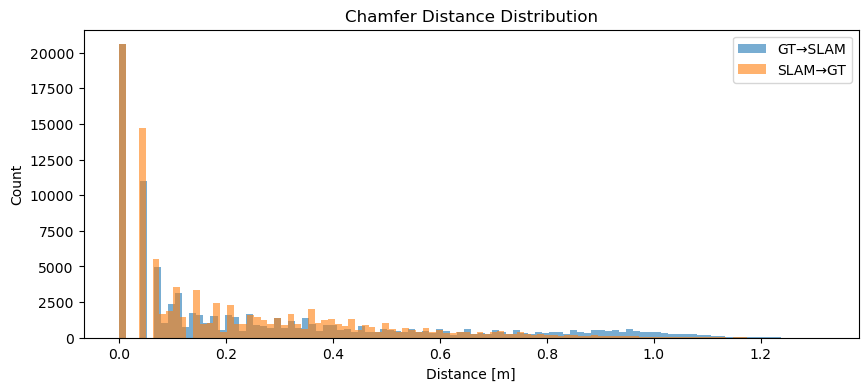

Mean GT→SLAM: 0.273 m | Mean SLAM→GT: 0.216 m
Median Chamfer (overall): 0.122 m


In [19]:
chamfer_distance_o3d(original_map, clean_map)

#### Chamfer Distance (Origina vs Noisy-PCL)

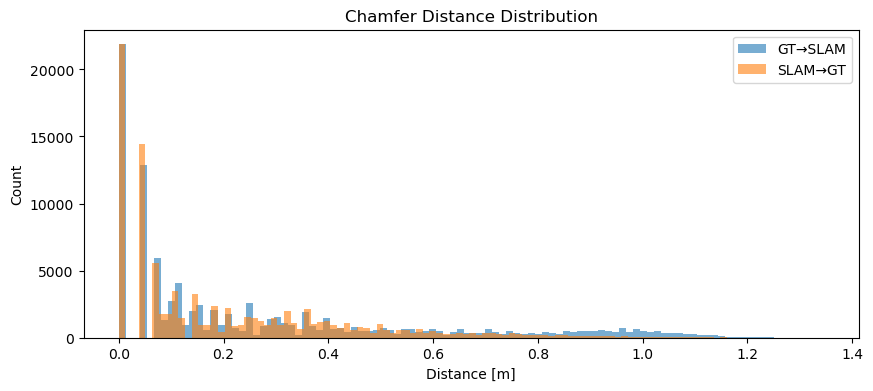

Mean GT→SLAM: 0.274 m | Mean SLAM→GT: 0.209 m
Median Chamfer (overall): 0.122 m


In [20]:
chamfer_distance_o3d(original_map, noisy_map)

### F-score @ τ (Precision / Recall)
Description: A classification metric at a distance threshold τ (e.g. 0.1 m):
- Precision: % of SLAM points that are within τ of GT (low FP).
- Recall: % of GT points that are within τ of SLAM (coverage).
- F-score: Harmonic mean of precision & recall (balance between the two).

Interpretation: 
- F-score ≈ 1.0: Excellent reconstruction.
- Precision < Recall: Too many outliers/artifacts.
- Recall < Precision: Your SLAM map is sparse or incomplete.
Try multiple τ values (0.05 m, 0.1 m, 0.2 m) to see how robust results are.

#### F-score @ τ (Origina vs Clean-PCL)

In [21]:
fscore_at_tau_o3d(original_map, clean_map, tau=0.2)
fscore_at_tau_o3d(original_map, clean_map, tau=0.1)
fscore_at_tau_o3d(original_map, clean_map, tau=0.05)

F-score @τ=0.20 m → Precision: 0.567 | Recall: 0.592 | F-score: 0.579
F-score @τ=0.10 m → Precision: 0.428 | Recall: 0.447 | F-score: 0.438
F-score @τ=0.05 m → Precision: 0.323 | Recall: 0.328 | F-score: 0.325


#### F-score @ τ (Origina vs Noisy-PCL)

In [22]:
fscore_at_tau_o3d(original_map, noisy_map, tau=0.2)
fscore_at_tau_o3d(original_map, noisy_map, tau=0.1)
fscore_at_tau_o3d(original_map, noisy_map, tau=0.05)

F-score @τ=0.20 m → Precision: 0.573 | Recall: 0.601 | F-score: 0.586
F-score @τ=0.10 m → Precision: 0.427 | Recall: 0.459 | F-score: 0.442
F-score @τ=0.05 m → Precision: 0.314 | Recall: 0.338 | F-score: 0.325


### Error Distribution (Percentiles)
Description: Computes per-point SLAM→GT nearest neighbor error and summarizes it with p50 / p90 / p95 / p99 percentiles + histogram.

Interpretation: 
- p50 (median): Typical reconstruction error.
- p90 / p95: “worst-case” errors for the majority of points.
- Gap between p90 & p99: If large, there are a few catastrophic outliers → check those regions.
Histogram shape tells you if errors are localized (sharp spike near 0) or spread out (broad tail).

#### Error Distribution (Origina vs Clean-PCL)

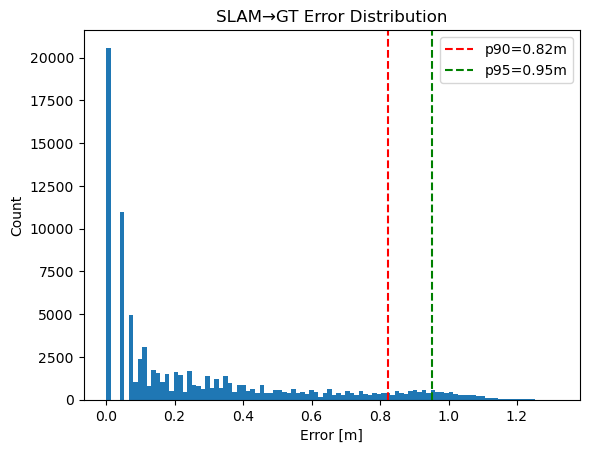

Median: 0.141 m | p90: 0.825 m | p95: 0.953 m | p99: 1.083 m


In [23]:
error_distribution_o3d(original_map, clean_map)

#### Error Distribution (Origina vs Noisy-PCL)

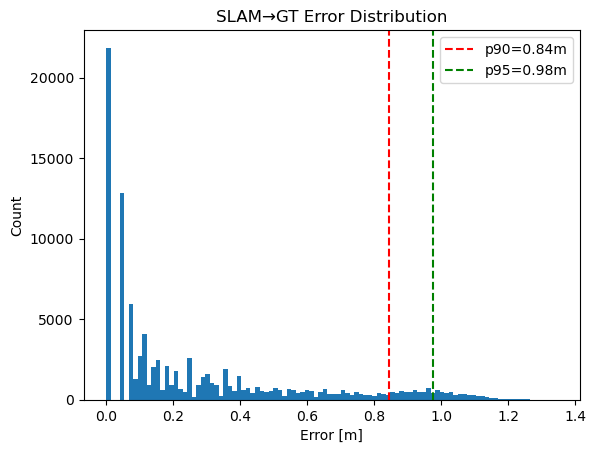

Median: 0.141 m | p90: 0.844 m | p95: 0.976 m | p99: 1.108 m


In [24]:
error_distribution_o3d(original_map, noisy_map)

## Visualization

#### Error colormap (Origina vs Clean-PCL)

In [25]:
visualize_error_colormap(original_map, clean_map)

#### Error colormap (Origina vs Clean-PCL)

In [26]:
visualize_error_colormap(original_map, noisy_map)